# Задание

Построить классификатор для задачи "Sentiment analysis", при условии, что на вход сети подается текст и его тема (датасет — `./data/lenta_labels_sentiment.xlsx`).
* В архитектуре сети обязательно использование эмбеддингов и RNN.
* Качество предсказаний должно быть не ниже 0.7 F-score.

# Настройки/Импорты

Версии важных модулей:
* pandas==2.1.1
* numpy==1.26.2
* keras==3.3.3
* tensorflow==2.16.1 (no GPU)
* matplotlib==3.6.2
* navec==0.10.0

In [1]:
# !pip install navec

In [2]:
import numpy as np # для работы с массивами
import pandas as pd # для удобной работы с датасетом

from tensorflow.keras.preprocessing.text import Tokenizer # токенизатор текста (на версии keras 2.15.0 можно было не тягать из tensorflow)
from navec import Navec # для русскоязычных эмбеддингов
from sklearn.utils import resample # для upsample и downsample данных (выравнивание классов)
from sklearn.model_selection import train_test_split # для разбиения на обучающую и тестовую выборку

from keras.layers import Input, Dense, concatenate, Embedding, SimpleRNN, Dropout, Flatten, Reshape # слои для нейронной сети
from keras.models import Model # Keras модель (не последовательная)
from keras.callbacks import ModelCheckpoint, EarlyStopping # callback функции
import keras # для работы с моделью
from tensorflow.keras import backend as K # для дополнительных метрик качества (на версии keras 2.15.0 можно было не тягать из tensorflow)

import matplotlib.pyplot as plt # для построения графиков
import time # для отслеживания времени выполнения
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay # для оценки качества предсказаний

In [3]:
DATA_DIR = "./data/" # путь до папки с данными
EMBEDDING_DIR = "./embeddings/" # путь до папки с эмбеддингами
MODELS_DIR = "./models/" # путь до папки с моделями
RANDOM_STATE = 42 # число для задания случайности
DTYPE = np.float32 # используемый тип

MAX_FEATURES = 10000 # максимальное число фич (самых встречаемых токенов) в словаре векторизатора (токенизатора)
EMBEDDING_DIM = 300 # размерность вектора-эмбеддинга слова

SAMPLES_PER_CLASS = 3000 # сколько должно быть сэмплов в каждом классе при обучении
TEST_SIZE = 0.2 # размер тестовой выборки

EPOCHS = 25 # число эпох обучения
PATIENCE_EPOCHS = 10 # число эпох без изменения наблюдаемой метрики, после которого обучение прекратится
LEARNING_RATE = 0.0001 # learning rate
BATCH_SIZE = 128 # размер батча (число сэмплов, передаваемых в модель одновременно)

In [4]:
from google.colab import drive # для Google Drive
drive.mount('/content/drive') # подключаемся к Google Drive

# перезаписываем важные переменные
DATA_DIR = "/content/drive/MyDrive/tmp/data/" # путь до папки с данными
EMBEDDING_DIR = "/content/drive/MyDrive/tmp/embeddings/" # путь до папки с эмбеддингами
MODELS_DIR = "/content/drive/MyDrive/tmp/models/" # путь до папки с моделями

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Предобработка датасета

## Изначальные данные

In [5]:
dataset = pd.read_excel(DATA_DIR + "lenta_labels_sentiment.xlsx", index_col=0) # считывание excel данных (index_col=0 — первый столбец использовать как индексы в DataFrame)
dataset

,original data,topics,sentiment
0,жёсткий_санкция анонсировать совет_безопаснос...,политика,NEUTRAL
1,участница китай генерация ссылка банка_развит...,экономика_и_финансы,NEUTRAL
2,кандидат снятие солнечный_система поверхность...,наука_и_техника,NEUTRAL
3,очевидец проходить ссылка сотня вконтакте пра...,происшествия,NEGATIVE
4,произойти_пожар осложняться правоохранительны...,происшествия,NEGATIVE
...,...,...,...
8645,союз_европейский марсел полиция посольство...,спорт,NEUTRAL
8646,падение сотрудник_служба_безопасность авиа...,происшествия,NEGATIVE
8647,выехать руководитель федеральный_трасса дт...,происшествия,NEGATIVE
8648,марсел полиция страна подопечный_леонид_сл...,спорт,NEGATIVE


Изначальное распределение тем и тональности в датасете.

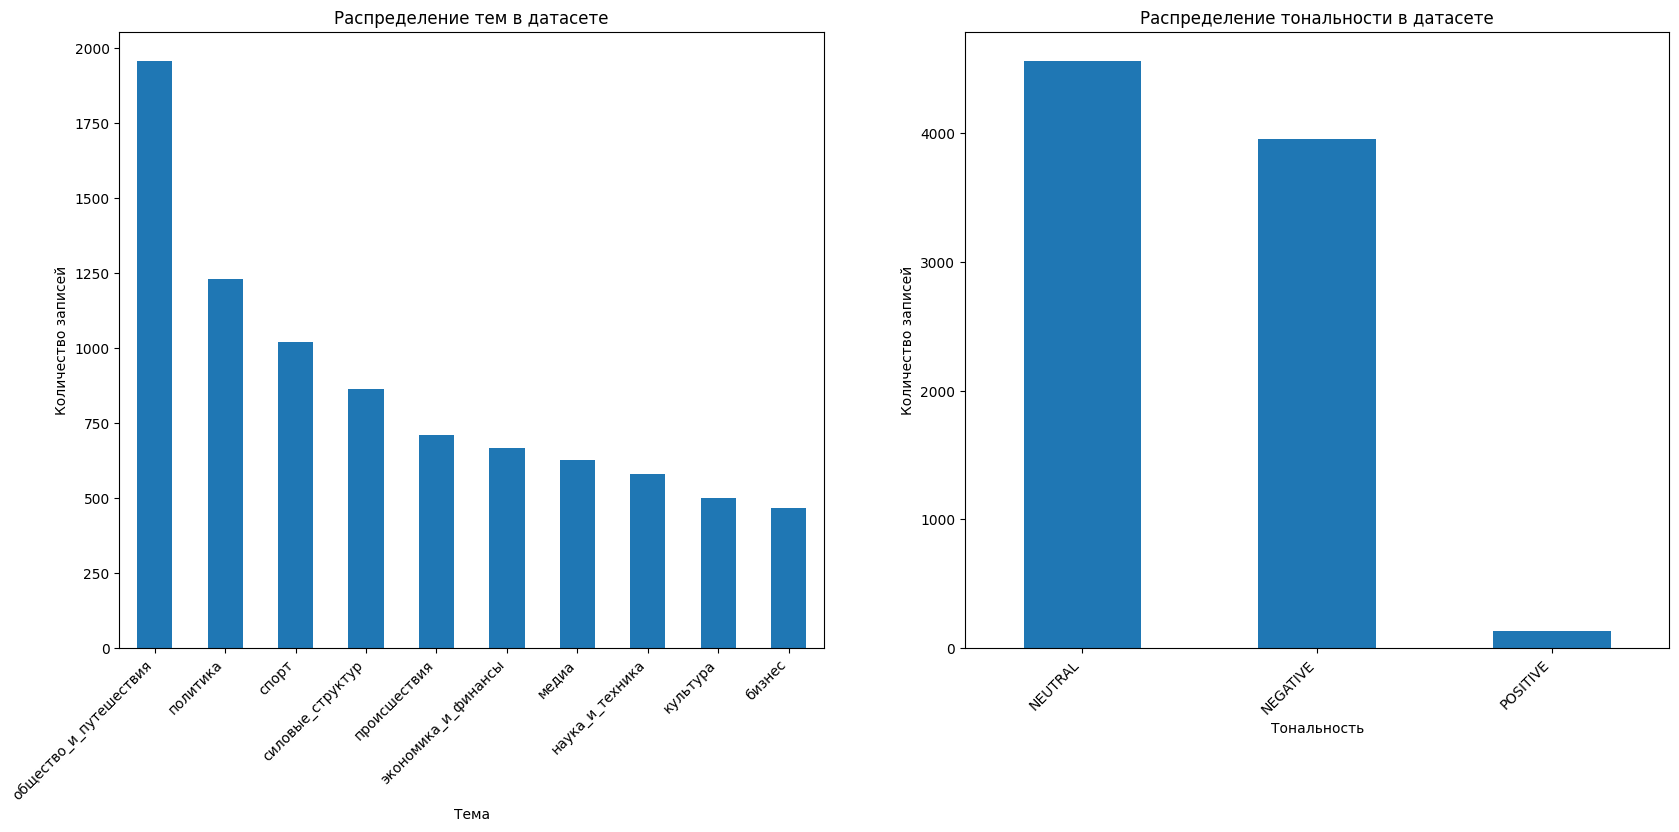

In [6]:
fig, axes = plt.subplots(ncols=2, figsize=(20,8)) # создаём фигуру с несколькими подграфиками (ncols и/или nrows) размера figsize

dataset["topics"].value_counts().plot.bar(ax=axes[0]) # построение столбчатой диаграммы по данным на оси ax
axes[0].set_xticklabels(axes[0].get_xticklabels(), ha='right', rotation=45) # добавление rotation для существующих xticks (get_xticklabels) с выравниванием по правому концу (ha='right')
axes[0].set_title("Распределение тем в датасете") # название фигуры
axes[0].set_xlabel("Тема") # подпись по оси OX
axes[0].set_ylabel("Количество записей") # подпись по оси OY

dataset["sentiment"].value_counts().plot.bar(ax=axes[1]) # построение столбчатой диаграммы по данным на оси ax
axes[1].set_xticklabels(axes[1].get_xticklabels(), ha='right', rotation=45) # добавление rotation для существующих xticks (get_xticklabels) с выравниванием по правому концу (ha='right')
axes[1].set_title("Распределение тональности в датасете") # название фигуры
axes[1].set_xlabel("Тональность") # подпись по оси OX
axes[1].set_ylabel("Количество записей") # подпись по оси OY

plt.show() # показ фигуры

Тексты в датасете уже очищены. Поэтому из предобработки нужно только сделать **токенизацию** с последующим **эмбеддингом** текстов и **One-hot encoding** столбцов темы и тональности, тональности — чтобы работать с **Cross-entropy loss**.

## Колонка "original data" с текстами:

### Токенизация

In [7]:
tokenizer = Tokenizer(num_words=MAX_FEATURES, filters='!–"—#$%&amp;()*+,-./:;<=>?@[\\]^_`{|}~\t\n\r«»', lower=True, split=" ", char_level=False, oov_token='<OOV>') # создаём объект токенизатора, с максимальным числом токенов=MAX_FEATURES (останутся только самые встречаемые слова)
tokenizer.fit_on_texts(dataset['original data']) # обучаем токенизатор на текстах

encoded_docs = tokenizer.texts_to_matrix(dataset['original data'], mode='tfidf') # преобазовываем тексты в матрицу размерности (число документов, максимальное число токенов)
print(f"Размерность TF-IDF матрицы: {encoded_docs.shape}.")
print(encoded_docs) # получившаяся TF-IDF матрица (np.array)
# первое число всегда ноль — из-за нумерации слов с 1, затем идёт токен Out Of Vocabulary (<OOV>), потом числа соответствующие другим словам из tokenizer.index_word

Размерность TF-IDF матрицы: (8650, 10000).
[[ 0.         19.02482322  0.         ...  0.          0.
   0.        ]
 [ 0.          9.0654302   2.01956492 ...  0.          0.
   0.        ]
 [ 0.         28.98421624  0.         ...  0.          0.
   0.        ]
 ...
 [ 0.         19.02482322  0.         ...  0.          0.
   0.        ]
 [ 0.          9.0654302   2.01956492 ...  0.          0.
   0.        ]
 [ 0.         15.34910758  2.01956492 ...  0.          0.
   0.        ]]


In [8]:
word2id = tokenizer.word_index # словарь соответствия слова его id_шнику (не ограничены MAX_FEATURES)

id2word = tokenizer.index_word # словарь соответствия id_шника слову (не ограничены MAX_FEATURES)
print(f"Число уникальных слов в корпусе: {len(id2word)}.")
id2word

Число уникальных слов в корпусе: 19380.


{1: '<OOV>',
 2: 'россия',
 3: 'российский',
 4: 'страна',
 5: 'президент',
 6: 'компания',
 7: 'тысяча',
 8: 'сша',
 9: 'глава',
 10: 'москва',
 11: 'место',
 12: 'процент',
 13: 'результат',
 14: 'миллион',
 15: 'рубль',
 16: 'представитель',
 17: 'город',
 18: 'решение',
 19: 'министр',
 20: 'организация',
 21: 'новый',
 22: 'доллар',
 23: 'летний',
 24: 'работа',
 25: 'произойти',
 26: 'большой',
 27: 'отношение',
 28: 'суд',
 29: 'государство',
 30: 'международный',
 31: 'американский',
 32: 'новость',
 33: 'сотрудник',
 34: 'часть',
 35: 'область',
 36: 'имя',
 37: 'группа',
 38: 'провести',
 39: 'полиция',
 40: 'конец',
 41: 'пройти',
 42: 'власть',
 43: 'начало',
 44: 'вопрос',
 45: 'служба',
 46: 'территория',
 47: 'мужчина',
 48: 'мнение',
 49: 'военный',
 50: 'действие',
 51: 'владимир',
 52: 'команда',
 53: 'дом',
 54: 'уголовный',
 55: 'цена',
 56: 'украина',
 57: 'ряд',
 58: 'случай',
 59: 'помощь',
 60: 'ход',
 61: 'московский',
 62: 'официальный',
 63: 'миллиард',
 64: 

### Эмбеддинги

Для получения векторов-эмбеддингов воспользуемся [***Navec***](https://github.com/natasha/navec?tab=readme-ov-file), так как он компактный (легко умещается в память оперативную/физическую), хоть и имеет огромный словарь, и заточен под работу с русским языком. Словарь Navec содержит 500000 слов, представленных в виде векторов размерности 300.

In [9]:
navec = Navec.load(f"{EMBEDDING_DIR}navec_news_v1_1B_250K_300d_100q.tar") # загружаем вектора
# navec_news_v1_1B_250K_300d_100q.tar
#               |    |    |    |
#               |    |    |     ---- 100 dimentions after quantization
#               |    |     --------- original vectors have 300 dimentions
#               |     -------------- vocab size is 250 000 words + 2 for <unk>, <pad>
#                ------------------- dataset of 1 billion tokens was used

In [10]:
navec.get("россия") # пример работы Navec (возвращает np.array типа float32)

array([-1.84710979e-01, -1.11006454e-01,  8.64419341e-02,  2.27067307e-01,
        2.94272471e-02,  3.61244112e-01,  6.84306204e-01,  3.01842928e-01,
        5.98213494e-01,  3.27639431e-01, -8.99636969e-02, -4.26673051e-03,
       -1.35305882e-01, -1.53169289e-01, -9.85403955e-01,  4.16708700e-02,
       -1.14234546e-02,  2.78587669e-01,  3.62696052e-01,  1.83114067e-01,
       -5.30908763e-01, -8.31565708e-02, -2.97994286e-01,  3.76624703e-01,
       -2.12600291e-01, -3.43239874e-01, -1.70172006e-01,  5.35338342e-01,
        8.23401567e-03, -5.08584129e-03,  1.25565842e-01, -9.81486514e-02,
       -5.83348930e-01, -1.09766886e-01, -2.08152384e-01,  6.51811779e-01,
        2.57817626e-01,  1.24399737e-01,  9.33928668e-01,  2.06849694e-01,
        4.12415713e-01,  1.47891074e-01, -2.64007300e-01,  1.58391014e-01,
       -1.91531405e-01, -2.91673481e-01,  1.32743614e-02, -1.27170309e-01,
        3.30872774e-01, -5.01141660e-02,  3.88317481e-02, -8.73500109e-02,
       -4.95322235e-02,  

Заполняем матрицу эмбеддингов векторами, соответствующими словам (или нулями, если слова нет в словаре Navec).

In [11]:
embedding_matrix = np.zeros((MAX_FEATURES, EMBEDDING_DIM)) # создаём матрицу из нулей под эмбеддинги слов

skipped_words = [] # список под слова без вектора
for i in range(1, MAX_FEATURES): # идём по числу слов (токенов) в полученной TF-IDF матрице (encoded_docs)
    word = id2word[i] # слово, что идёт под номером i в токенизаторе (столбец i в TF-IDF матрице)
    if navec.get(word) is not None: # если у рассматриваемого слова есть вектор в Navec (иначе вернёт None)
        embedding_matrix[i] = navec.get(word) # записываем i-ый вектор в матрицу эмбеддингов
    else: # если слова нет в Navec
        skipped_words.append(word) # добавляем слово в список пропущенных

print(f"Пропущенно {len(skipped_words)} слов из {MAX_FEATURES}.")

Пропущенно 462 слов из 10000.


## Колонки "topics" и "sentiment":

### One-hot encoding

In [12]:
ohe_columns = ["topics", "sentiment"] # колонки, что нужно обработать One-hot кодированием
ohe_data = {} # словарь под обработанные данные (столбцы)

for col in ohe_columns: # идём по колонкам для One-hot encodding_а
    ohe_data[col] = pd.get_dummies(dataset[col]) # делаем One-hot encoding для указанных колонок датасета
    print(f"Размерность данных '{col}' после One-hot кодирования: {ohe_data[col].shape}.")

Размерность данных 'topics' после One-hot кодирования: (8650, 10).
Размерность данных 'sentiment' после One-hot кодирования: (8650, 3).


In [13]:
ohe_data["topics"] # пример того, что получается после One-hot кодирования

,бизнес,культура,медиа,наука_и_техника,общество_и_путешествия,политика,происшествия,силовые_структур,спорт,экономика_и_финансы
0,False,False,False,False,False,True,False,False,False,False
1,False,False,False,False,False,False,False,False,False,True
2,False,False,False,True,False,False,False,False,False,False
3,False,False,False,False,False,False,True,False,False,False
4,False,False,False,False,False,False,True,False,False,False
...,...,...,...,...,...,...,...,...,...,...
8645,False,False,False,False,False,False,False,False,True,False
8646,False,False,False,False,False,False,True,False,False,False
8647,False,False,False,False,False,False,True,False,False,False
8648,False,False,False,False,False,False,False,False,True,False


In [14]:
ohe_data["sentiment"] # пример того, что получается после One-hot кодирования

,NEGATIVE,NEUTRAL,POSITIVE
0,False,True,False
1,False,True,False
2,False,True,False
3,True,False,False
4,True,False,False
...,...,...,...
8645,False,True,False
8646,True,False,False
8647,True,False,False
8648,True,False,False


## Train-test split

Объединим TF-IDF матрицу и One-hot колонки "topic" в один pd.DataFrame.

In [15]:
columns = [0] # список с колонками для общего датасета, 0 под пропуск (padding) на первом месте (слова нумеруются с 1)
columns.extend([id2word[id] for id in range(1, MAX_FEATURES)]) # добавляем слова по их id (чем чаще слово — тем меньше его id)

In [16]:
dataset_processed = pd.DataFrame(encoded_docs, columns=columns) # заготовка pd.DataFrame для всех данных
dataset_processed = pd.concat([dataset_processed, ohe_data["topics"]], axis=1) # объединяем с One-hot encoded столбцом (он уже идёт как pd.DataFrame)
dataset_processed # включает оба входа для модели (TF-IDF матрицу и One-hot encoded "topics")

,0,<OOV>,россия,российский,страна,президент,компания,тысяча,сша,глава,...,бизнес,культура,медиа,наука_и_техника,общество_и_путешествия,политика,происшествия,силовые_структур,спорт,экономика_и_финансы
0,0.0,19.024823,0.000000,0.000000,1.597159,0.0,0.0,1.828828,2.076413,0.000000,...,False,False,False,False,False,True,False,False,False,False
1,0.0,9.065430,2.019565,1.596796,2.704225,0.0,0.0,0.000000,0.000000,0.000000,...,False,False,False,False,False,False,False,False,False,True
2,0.0,28.984216,0.000000,0.000000,0.000000,0.0,0.0,0.000000,2.076413,0.000000,...,False,False,False,True,False,False,False,False,False,False
3,0.0,15.349108,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,...,False,False,False,False,False,False,True,False,False,False
4,0.0,19.024823,1.192788,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,...,False,False,False,False,False,False,True,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8645,0.0,19.024823,2.503199,2.703610,1.597159,0.0,0.0,0.000000,0.000000,0.000000,...,False,False,False,False,False,False,False,False,True,False
8646,0.0,0.000000,0.000000,0.000000,1.597159,0.0,0.0,0.000000,0.000000,0.000000,...,False,False,False,False,False,False,True,False,False,False
8647,0.0,19.024823,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,...,False,False,False,False,False,False,True,False,False,False
8648,0.0,9.065430,2.019565,3.351055,1.597159,0.0,0.0,0.000000,0.000000,1.980379,...,False,False,False,False,False,False,False,False,True,False


Делаем split с учётом представленности тональностей.

In [17]:
X_train, X_test, y_train, y_test = train_test_split(dataset_processed, ohe_data["sentiment"], test_size=TEST_SIZE, random_state=RANDOM_STATE, stratify=ohe_data["sentiment"], shuffle=True)
# разбиваем датасет (dataset_processed — данные, ohe_data["sentiment"] — таргеты) на обучающую и тестовую выборки в соотношении TEST_SIZE, при этом пропорция таргетов должна быть одинаковой (stratify=ohe_data["sentiment"]) в обоих выборках и данные должны быть перемешаны (shuffle=True)

## Resampling

Делаем resampling для того, чтобы при ***обучении*** классы были представлены одинаково.

In [18]:
if SAMPLES_PER_CLASS: # если число сэплов за класс задано
    max_samples = SAMPLES_PER_CLASS # используем его как параметр для resample
else: # иначе — выравниваем по самому представленному классу
    max_samples = ohe_data["sentiment"].value_counts()[0] # число элементов в наиболее представленном классе
print(f"Размерность до resample: сэмплов — {X_train.shape[0]}, фич — {X_train.shape[1]}.")

# сначала получаем данные о распределении фич для каждого класса, чтобы потом провести их выравнивание (upsampling)
y_values = y_train.idxmax(axis=1) # обратно преобразовываем One-hot таргеты в один столбец (только для поиска распределения данных X)
y_unique = y_values.unique() # уникальные значения таргетов (совпадают с колонками One-hot, то есть NEGATIVE, NEUTRAL, POSITIVE)
data_resampled = pd.DataFrame(columns=list(X_train.columns).extend(y_unique)) # заготовка под DataFrame без дисбаланса классов (слолбцы: X_train.columns фич и One-hot таргет)
for target_value in y_unique: # идём по уникальным таргетам
    data_distribution = X_train[y_values == target_value] # записываем в data_distribution TF-IDF вектора, соответствующие рассматриваемому target_value
    print(f"    В классе '{target_value}' было {len(data_distribution)} записей.")

    data_distribution = resample(data_distribution, n_samples=max_samples, random_state=RANDOM_STATE) # добавляем (удаляем) записи к рассматриваемому таргету до n_samples по соответствующему распределению
    print(f"    В классе '{target_value}' стало {len(data_distribution)} записей.")

    data_for_label = pd.DataFrame(data_distribution) # создаём DataFrame из векторов, соответствующих рассматриваемому таргету
    data_for_label[y_unique] = pd.DataFrame([y_train[y_values == target_value].iloc[0]], index=data_for_label.index) # добавляем колонки One-hot таргета в DataFrame (index=data_for_label.index — у всех строк будет значение рассматриваемого таргета) (.iloc[0] — берём первое значение One-hot вектора таргета, что совпало по инексу с его не One-hot версией)
    data_resampled = pd.concat([data_resampled, data_for_label]) # соединяем вместе все DataFrame_ы классов

data_resampled = data_resampled.sample(frac=1) # случайным образом перемешиваем датасет

y_train = data_resampled[y_unique] # запоминаем таргеты (One-hot)
data_resampled.drop(y_unique, axis=1, inplace=True) # в data_resampled (DataFrame) оставляем только вектора фич
X_train = data_resampled # запоминаем фичи

print(f"Размерность после resample: сэмплов — {X_train.shape[0]}, фич — {X_train.shape[1]}.")

Размерность до resample: сэмплов — 6920, фич — 10010.
    В классе 'NEGATIVE' было 3164 записей.
    В классе 'NEGATIVE' стало 3000 записей.
    В классе 'NEUTRAL' было 3648 записей.
    В классе 'NEUTRAL' стало 3000 записей.
    В классе 'POSITIVE' было 108 записей.
    В классе 'POSITIVE' стало 3000 записей.
Размерность после resample: сэмплов — 9000, фич — 10010.


Очищаем память из под вспомогательных объектов.

In [19]:
del data_distribution
del data_for_label
del data_resampled
del dataset_processed

Распределение таргетов после resample.

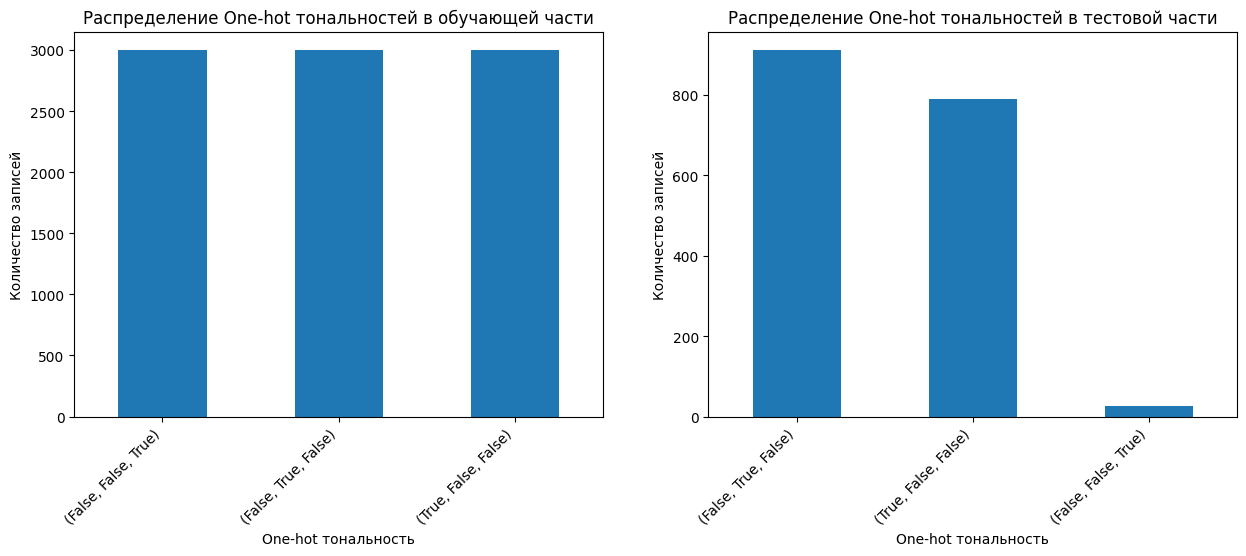

In [20]:
fig, axes = plt.subplots(ncols=2, figsize=(15,5)) # создаём фигуру с несколькими подграфиками (ncols и/или nrows) размера figsize

y_train.value_counts().plot.bar(ax=axes[0]) # построение столбчатой диаграммы по данным на оси ax
axes[0].set_xticklabels(axes[0].get_xticklabels(), ha='right', rotation=45) # добавление rotation для существующих xticks (get_xticklabels) с выравниванием по правому концу (ha='right')
axes[0].set_title("Распределение One-hot тональностей в обучающей части") # название фигуры
axes[0].set_xlabel("One-hot тональность") # подпись по оси OX
axes[0].set_ylabel("Количество записей") # подпись по оси OY

y_test.value_counts().plot.bar(ax=axes[1]) # построение столбчатой диаграммы по данным на оси ax
axes[1].set_xticklabels(axes[1].get_xticklabels(), ha='right', rotation=45) # добавление rotation для существующих xticks (get_xticklabels) с выравниванием по правому концу (ha='right')
axes[1].set_title("Распределение One-hot тональностей в тестовой части") # название фигуры
axes[1].set_xlabel("One-hot тональность") # подпись по оси OX
axes[1].set_ylabel("Количество записей") # подпись по оси OY

plt.show() # показ фигуры

Разобьём данные X на несколько частей (входов модели) — части, отвечающие за векторизированный текст и One-hot столбцы "topics".

А также сконвертируем всё в np.array.

In [21]:
columns_input_1 = X_train.columns[:MAX_FEATURES] # столбцы, отвечающие за первый вход в модель
columns_input_2 = X_train.columns[MAX_FEATURES:] # столбцы, отвечающие за второй вход в модель

# плохой вариант, так как "topics" совпадают с обычными словами
# X_train_1 = X_train[columns_input_1].values.astype(DTYPE) # данные на первый вход (приведённые к типу DTYPE) в виде np.array
# X_train_2 = X_train[columns_input_2].values.astype(DTYPE) # данные на второй вход (приведённые к типу DTYPE) в виде np.array
X_train_1 = X_train.iloc[:, :MAX_FEATURES].values.astype(DTYPE) # данные (все строки, а столбцы ограничены числом рассматриваемых токенов) на первый вход (приведённые к типу DTYPE) в виде np.array
X_train_2 = X_train.iloc[:, MAX_FEATURES:].values.astype(DTYPE) # данные (все строки, а столбцы ограничены числом после рассматриваемых токенов) на первый вход (приведённые к типу DTYPE) в виде np.array
y_train = y_train.values.astype(DTYPE) # таргеты в виде np.array (приведённые к типу DTYPE)

# аналогично для тестовой части
# X_test_1 = X_test[columns_input_1].values.astype(DTYPE) # данные на первый вход (приведённые к типу DTYPE) в виде np.array
# X_test_2 = X_test[columns_input_2].values.astype(DTYPE) # данные на второй вход (приведённые к типу DTYPE) в виде np.array
X_test_1 = X_test.iloc[:, :MAX_FEATURES].values.astype(DTYPE) # данные (все строки, а столбцы ограничены числом рассматриваемых токенов) на первый вход (приведённые к типу DTYPE) в виде np.array
X_test_2 = X_test.iloc[:, MAX_FEATURES:].values.astype(DTYPE) # данные (все строки, а столбцы ограничены числом после рассматриваемых токенов) на первый вход (приведённые к типу DTYPE) в виде np.array
y_test = y_test.values.astype(DTYPE) # таргеты в виде np.array (приведённые к типу DTYPE)

In [22]:
print(f"Shape данных на первый вход: сэмплов — {X_train_1.shape[0]}, фич (TF-IDF matrix) — {X_train_1.shape[1]}.")
print(f"Shape данных на второй вход: сэмплов — {X_train_2.shape[0]}, фич (One-hot encoded) — {X_train_2.shape[1]}.")
print(f"Shape выхода модели: сэмплов — {y_train.shape[0]}, таргетов (One-hot encoded) — {y_train.shape[1]}.")

Shape данных на первый вход: сэмплов — 9000, фич (TF-IDF matrix) — 10000.
Shape данных на второй вход: сэмплов — 9000, фич (One-hot encoded) — 10.
Shape выхода модели: сэмплов — 9000, таргетов (One-hot encoded) — 3.


# Работа с моделью

## Основная структура модели

In [23]:
text_input_size = MAX_FEATURES # размер вектора данных на первый вход, совпадает с размером вектора документа в TF-IDF представлении
topic_input_size = len(columns_input_2) # размер вектора данных на второй вход (число тем в корпусе)

In [24]:
# первая часть модели, обрабатывающая вектора из TF-IDF матрицы
layer_input_1 = Input(shape=(text_input_size,), dtype=DTYPE, name='input_text') # первый входной слой модели, получает вектор размера (BATCH_SIZE, число слов или токенов в строке матрицы TF-IDF)
layer_embedding = Embedding(input_dim=MAX_FEATURES, output_dim=EMBEDDING_DIM, input_length=text_input_size, name='embedding')(layer_input_1) # слой эмбеддинга (на вход — layer_input_1, выход размерности (BATCH_SIZE,  число слов или токенов в строке матрицы TF-IDF, размерность вектора-эмбеддинга))
# input_dim — число фич/параметров, input_length — размер последовательности (в данном случае из-за TF-IDF они совпадают)

# Reshape нужен, если вход в RNN не трёхмерный (в данном случае он трёхмерный из-за слоя Embedding)
# return_sequences=False — возвращает вектор (двумерный) для слоя Dense (иначе — вернёт трёхмерный тензор, что мог ожидаться в следующем слое модели, что назывался бы так же ~ RNN)
# layer_rnn_1 = SimpleRNN(units=64, activation='tanh', return_sequences=True, name='rnn_1')(layer_embedding) # RNN слой модели, передающий данные в следующую RNN (return_sequences=True), выход размерности (BATCH_SIZE, число слов или токенов в строке матрицы TF-IDF, 64))
# layer_rnn_2 = SimpleRNN(units=32, activation='tanh', return_sequences=False, name='rnn_2')(layer_rnn_1) # RNN слой модели, передающий данные полносвязный слой (return_sequences=False), выход размерности (BATCH_SIZE, 32))
layer_rnn_1 = SimpleRNN(units=64, activation=None, return_sequences=False, name='rnn_1')(layer_embedding) # RNN слой модели, передающий данные в следующую RNN (return_sequences=True), выход размерности (BATCH_SIZE, число слов или токенов в строке матрицы TF-IDF, 64))
layer_linear_1_1 = Dense(units=32, activation="relu", name='dense_after_rnn')(layer_rnn_1) # полносвязный (линейный) слой после RNN из 64 нейронов, выход будет иметь размерность (BATCH_SIZE, 32)
model_1 = Model(inputs=layer_input_1, outputs=layer_linear_1_1) # объединяем первую часть модели


# вторая часть модели, обрабатывающая One-hot вектора тем новостей
layer_input_2 = Input(shape=(topic_input_size,), dtype=DTYPE, name='input_topics') # второй входной слой модели, получает вектор размера (BATCH_SIZE, число тем в корпусе)
layer_linear_2_1 = Dense(units=64, activation=None, name='dense_after_second_input_1')(layer_input_2) # полносвязный (линейный) слой для второго входа, выход будет иметь размерность (BATCH_SIZE, 64)
layer_linear_2_2 = Dense(units=32, activation="relu", name='dense_after_second_input_2')(layer_linear_2_1) # полносвязный (линейный) слой для второго входа, выход будет иметь размерность (BATCH_SIZE, 32)
model_2 = Model(inputs=layer_input_2, outputs=layer_linear_2_2) # объединяем вторую часть модели


# объединение моделей в одну
combined = concatenate([model_1.output, model_2.output]) # сливаем модели (выход объединяемых моделей должен иметь одну и ту же размерность, в данном случае — (BATCH_SIZE, 32))
layer_linear_3_1 = Dense(units=64, activation=None, name='dense_combined_1')(combined) # полносвязный (линейный) слой после объединения, выход будет иметь размерность (BATCH_SIZE, 64)
layer_dropout = Dropout(rate=0.2, name='dropout')(layer_linear_3_1) # слой dropout для борьбы с переобучением
layer_linear_3_2 = Dense(units=32, activation="relu", name='dense_combined_2')(layer_dropout) # ещё один полносвязный (линейный) слой, выход будет иметь размерность (BATCH_SIZE, 32)
# layer_output = Dense(units=3, activation="sigmoid", name='dense_sigmoid')(layer_linear_3_2) # activation="sigmoid" для получения вероятностей каждого класса отдельно, выход будет иметь размерность (BATCH_SIZE, 3)
layer_output = Dense(units=3, activation="softmax", name='dense_softmax')(layer_linear_3_2) # activation="softmax" для получения вероятностей класов (тональности), выход будет иметь размерность (BATCH_SIZE, 3)
model = Model(inputs=[model_1.input, model_2.input], outputs=layer_output) # финальное объединение в одну модель

model.summary() # вывод данных о модели

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_text (InputLayer)     [(None, 10000)]              0         []                            
                                                                                                  
 embedding (Embedding)       (None, 10000, 300)           3000000   ['input_text[0][0]']          
                                                                                                  
 input_topics (InputLayer)   [(None, 10)]                 0         []                            
                                                                                                  
 rnn_1 (SimpleRNN)           (None, 64)                   23360     ['embedding[0][0]']           
                                                                                            

Устанавливаем специфичные веса и параметры обучения для слоя эмбеддинга.

In [25]:
print(f"Слой эмбеддинга: {model.layers[1]}")
model.layers[1].set_weights([embedding_matrix]) # устанавливаем вектора эмбеддингов
model.layers[1].trainable = False # ставим флаг, что слой не будет обучаться

Слой эмбеддинга: <keras.src.layers.core.embedding.Embedding object at 0x79222fb0f100>


## Оптимизатор обучения модели

In [26]:
optimizer = keras.optimizers.Adam(learning_rate=LEARNING_RATE) # оптимизатор обучения модели

## Дополнительные метрики для модели

In [27]:
# # у всех добавляемых метрик требуется приписка _m в конце названия
# @keras.saving.register_keras_serializable()
# def precision_m(y_true, y_pred):
#     true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
#     predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
#     precision = true_positives / (predicted_positives + K.epsilon())
#     return precision

# @keras.saving.register_keras_serializable()
# def recall_m(y_true, y_pred):
#     true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
#     possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
#     recall = true_positives / (possible_positives + K.epsilon())
#     return recall

# @keras.saving.register_keras_serializable()
# def f1_m(y_true, y_pred):
#     precision = precision_m(y_true, y_pred)
#     recall = recall_m(y_true, y_pred)
#     return 2*((precision*recall)/(precision+recall+K.epsilon()))

## Callback функции

In [28]:
def get_early_stopping():
    """
    This function should return an EarlyStopping callback that stops learning when the
    validation (testing) accuracy has not improved over the last N epochs.
    """
    early_stopping = EarlyStopping(monitor="val_loss", mode="min", patience=PATIENCE_EPOCHS) # callback ранней остановки обучения
    # monitor — по какой метрике судить, нужно ли прекращать обучение, например - val_loss
    # mode — метрика должна увеличиваться или уменьшаться
    # patience — сколько должно пройти эпох без улучшения отслеживаемой метрики чтобы прекратить обучение
    return early_stopping


def get_checkpoint_best_only():
    """
    This function should return a ModelCheckpoint object that:
    - stores only those weights of the neural network that generate the highest accuracy during testing
    - saves to the 'checkpoints_best_only' directory inside the current working directory
    - generates a file named 'checkpoints_best_only/checkpoint'
    """
    checkpoint_best = ModelCheckpoint(filepath=f"{MODELS_DIR}best_model_tfidf.keras", save_best_only=True, save_weights_only=False, monitor="val_loss", mode="min") # callback сохранения чекпоинтов модели
    # filepath — путь до файла, куда сохранять (можно с указанием эпохи...)
    # save_best_only — сохранять только если результат (отслеживаемая метрика) улучшилась
    # save_weights_only — сохранять ли только веса
    # monitor — по какой метрике судить, стала ли модель лучше/хуже
    # mode — метрика должна увеличиваться или уменьшаться
    return checkpoint_best

## Сборка модели с обучением

In [29]:
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy']) # компилирование модели с указанием оптимизатора, функции потерь и дополнительных метрик
# model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=[precision_m, recall_m, 'accuracy', f1_m]) # компилирование модели с указанием оптимизатора, функции потерь и дополнительных метрик

In [30]:
callback_checkpoint = get_checkpoint_best_only() # callback сохранения чекпоинтов
callback_stopping = get_early_stopping() # callback ранней остановки обучения

callbacks = [callback_checkpoint, callback_stopping] # список callback_ов

In [31]:
time_start = time.time() # замеряем время начала обучения

history = model.fit(x=[X_train_1, X_train_2], y=y_train, epochs=EPOCHS, batch_size=BATCH_SIZE, validation_data=([X_test_1, X_test_2], y_test), callbacks=callbacks, verbose=1) # запускаем обучение модели (результатом которого будет история изменения метрик)
# x — вход модели (а данном случае — двойной)
# y — таргеты
# epochs — число эпох обучения
# batch_size — размер батчка
# validation_data — тестовые данные (тестовый двойной вход и его таргеты)
# callbacks — список callback функций
# verbose — на сколько подробно выводить информацию об обучении (1 - на каждой эпохе)

print(f"Время, затраченное на обучение: {time.time()  - time_start} секунд.")

Epoch 1/25
71/71 [==============================] - 774s 11s/step - loss: 1.1804 - accuracy: 0.3618 - val_loss: 1.1042 - val_accuracy: 0.3040
Epoch 2/25
71/71 [==============================] - 745s 10s/step - loss: 1.0789 - accuracy: 0.4374 - val_loss: 1.0937 - val_accuracy: 0.3913
Epoch 3/25
71/71 [==============================] - 753s 11s/step - loss: 1.0576 - accuracy: 0.4717 - val_loss: 1.0758 - val_accuracy: 0.4058
Epoch 4/25
71/71 [==============================] - 753s 11s/step - loss: 1.0354 - accuracy: 0.4981 - val_loss: 1.0640 - val_accuracy: 0.4162
Epoch 5/25
71/71 [==============================] - 760s 11s/step - loss: 1.0132 - accuracy: 0.5097 - val_loss: 1.0415 - val_accuracy: 0.4197
Epoch 6/25
71/71 [==============================] - 763s 11s/step - loss: 0.9943 - accuracy: 0.5147 - val_loss: 1.0205 - val_accuracy: 0.4283
Epoch 7/25
71/71 [==============================] - 747s 11s/step - loss: 0.9835 - accuracy: 0.5169 - val_loss: 1.0405 - val_accuracy: 0.4191
Epoch 

In [32]:
history_dict = history.history # словарь с историей обучения
print(history_dict.keys()) # ключи в словаре истории

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


In [33]:
model.save(f"{MODELS_DIR}final_model_tfidf.keras") # сохранение модели

## Оценка качества модели

Оценка обучения.

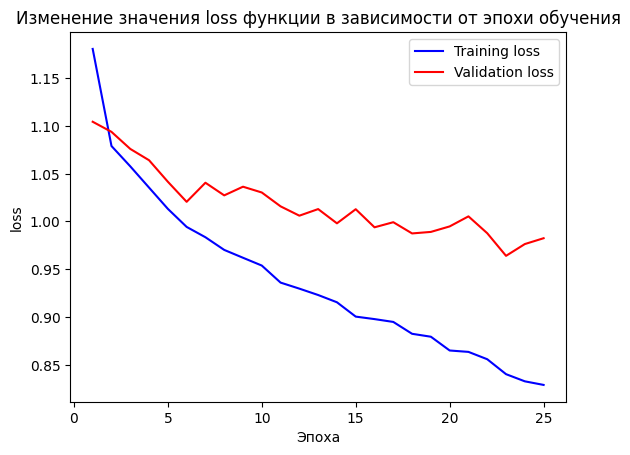

In [34]:
loss_train = history_dict['loss'] # значение loss при обучении
loss_val = history_dict['val_loss'] # значение loss при валидации
epochs = range(1, len(history_dict['loss']) + 1) # число эпох обучения (сколько было сохранено значений loss)
plt.plot(epochs, loss_train, 'b', label='Training loss') # построение линейного графика ('b' — синего цвета)
plt.plot(epochs, loss_val, 'r', label='Validation loss') # построение линейного графика ('r' — красного цвета)
plt.title("Изменение значения loss функции в зависимости от эпохи обучения") # название фигуры
plt.xlabel('Эпоха') # подпись по оси OX
plt.ylabel('loss') # подпись по оси OY
plt.legend() # вывод подписей для графиков
plt.show() # показ фигуры

Оценка качества предсказаний.

In [ ]:
model = keras.models.load_model(f"{MODELS_DIR}final_model_tfidf.keras") # загрузка модели

In [35]:
y_pred = model.predict([X_test_1, X_test_2]) # предсказание с помощью модели (вероятности классов NEGATIVE, NEUTRAL, POSITIVE)
print(f"Размерность предсказаний: {y_pred.shape}.")

55/55 [==============================] - 68s 1s/step
Размерность предсказаний: (1730, 3).


In [36]:
y_pred # премер выхода модели

array([[0.5135237 , 0.2400037 , 0.24647261],
       [0.6811371 , 0.26507613, 0.05378686],
       [0.36979958, 0.26231426, 0.36788604],
       ...,
       [0.72816914, 0.27073497, 0.00109588],
       [0.713108  , 0.24913478, 0.03775723],
       [0.36752552, 0.50844127, 0.12403329]], dtype=float32)

Вернёмся от One-hot encoded таргетов к обычным категориальным.

In [37]:
y_test = pd.DataFrame(y_test, columns=y_unique) # конвертируем тестовые таргеты обратно в DataFrame
y_pred = pd.DataFrame(y_pred, columns=y_unique) # конвертируем предсказаний обратно в DataFrame
y_pred

,NEGATIVE,NEUTRAL,POSITIVE
0,0.513524,0.240004,0.246473
1,0.681137,0.265076,0.053787
2,0.369800,0.262314,0.367886
3,0.317448,0.656576,0.025976
4,0.332167,0.598127,0.069706
...,...,...,...
1725,0.608148,0.363630,0.028222
1726,0.479851,0.481395,0.038754
1727,0.728169,0.270735,0.001096
1728,0.713108,0.249135,0.037757


In [38]:
y_test = y_test.idxmax(axis=1) # оставляем самый вероятный класс (его название)
y_pred = y_pred.idxmax(axis=1) # оставляем самый вероятный класс (его название)
y_pred

0       NEGATIVE
1       NEGATIVE
2       NEGATIVE
3        NEUTRAL
4        NEUTRAL
          ...   
1725    NEGATIVE
1726     NEUTRAL
1727    NEGATIVE
1728    NEGATIVE
1729     NEUTRAL
Length: 1730, dtype: object

              precision    recall  f1-score   support

    NEGATIVE       0.52      0.45      0.48       791
     NEUTRAL       0.60      0.45      0.51       912
    POSITIVE       0.03      0.41      0.06        27

    accuracy                           0.45      1730
   macro avg       0.38      0.44      0.35      1730
weighted avg       0.56      0.45      0.49      1730



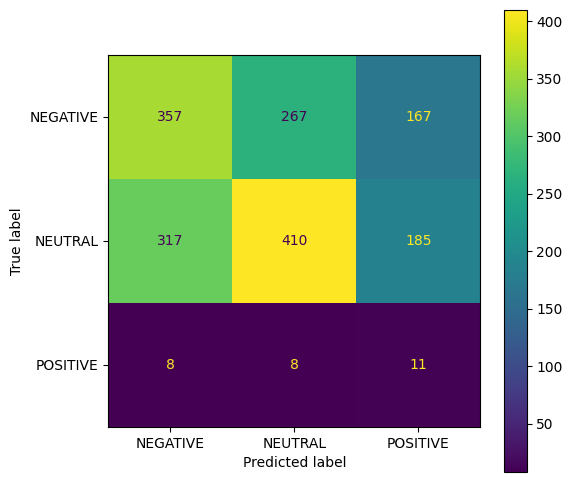

In [39]:
print(classification_report(y_test, y_pred, zero_division=0)) # выводим основные метрики, такие как precision, recall, f1-score, accuracy (zero_division=0 — деление на ноль заменять нулём)

fig, ax = plt.subplots(figsize=(6,6)) # создание "фигуры"
ConfusionMatrixDisplay(confusion_matrix(y_test, y_pred), display_labels=y_unique).plot(ax=ax) # строим confusion matrix (стоит обратить внимание на display_labels, они могут не совпасть...)
plt.show() # показ фигуры